In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from tqdm import tqdm
from models import Generator, Discriminator
import os
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
# CIFAR-10 dataset
transform = transforms.Compose([
                transforms.Resize(32),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])

train_dataset = datasets.CIFAR10(
    root="./data", train=True, transform=transform, download=True
)
train_loader = DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)

In [ ]:
cifar_mapping = ["airplane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [ ]:
def train_model(gen_pth=None, disc_pth=None, start_epoch=0, num_epochs=10, latent_size=100, save_epochs=50, 
                num_classes=10, progress_path="./progress", 
                models_path="./saved_models"):
    generator = Generator(latent_size, num_classes).to(device)
    discriminator = Discriminator().to(device)

    if gen_pth and disc_pth:
        generator.load_state_dict(torch.load(gen_pth))
        discriminator.load_state_dict(torch.load(disc_pth))

    if not os.path.exists(progress_path):
        os.makedirs(progress_path)
    if not os.path.exists(f"{progress_path}/static"):
        os.makedirs(f"{progress_path}/static")
    if not os.path.exists(f"{progress_path}/random"):
        os.makedirs(f"{progress_path}/random")
    if not os.path.exists(models_path):
        os.makedirs(models_path)
    if not os.path.exists(f"{models_path}/optimal"):
        os.makedirs(f"{models_path}/optimal")
    if not os.path.exists(f"{models_path}/epoch"):
        os.makedirs(f"{models_path}/epoch")

    adversarial_loss = nn.BCELoss()
    auxiliary_loss = nn.CrossEntropyLoss()

    z_static = torch.randn(10, latent_size).to(device)

    optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    # Training
    lowest_loss = np.inf
    if os.path.exists(f"{models_path}/loss.csv") and gen_pth is not None and disc_pth is not None:
        loss_df = pd.read_csv(f"{models_path}/loss.csv")
    else:
        loss_df = pd.DataFrame()
        
    for epoch in range(start_epoch, num_epochs):
        for _, (real_images, labels) in enumerate(tqdm(train_loader,  desc=f'Epoch {epoch}/{num_epochs}')):
            real_images = real_images.to(device)
            labels = labels.to(device)

            # Adversarial ground truths
            valid = torch.ones(real_images.size(0), 1).to(device)
            fake = torch.zeros(real_images.size(0), 1).to(device)

            # -----------------
            #  Train Generator
            # -----------------

            optimizer_G.zero_grad()

            # Sample noise and labels as generator input
            z = torch.randn(real_images.size(0), latent_size).to(device)
            gen_labels = torch.randint(0, 10, (real_images.size(0),)).to(device)
            one_hot_labels = F.one_hot(gen_labels, 10)
            input_vector = torch.cat((z, one_hot_labels.float()), dim=1)
            gen_images = generator(input_vector)

            # Loss measures generator's ability to fool the discriminator
            validity, pred_label = discriminator(gen_images)
            g_loss = 0.5 * (adversarial_loss(validity, valid) + auxiliary_loss(pred_label, gen_labels))

            g_loss.backward()
            optimizer_G.step()

            # ---------------------
            #  Train Discriminator
            # ---------------------

            optimizer_D.zero_grad()

            # Loss for real images
            real_pred, real_aux = discriminator(real_images)
            d_real_loss = (adversarial_loss(real_pred, valid) + auxiliary_loss(real_aux, labels)) / 2

            # Loss for fake images
            fake_pred, fake_aux = discriminator(gen_images.detach())
            d_fake_loss = (adversarial_loss(fake_pred, fake) + auxiliary_loss(fake_aux, gen_labels)) / 2

            # Total discriminator loss
            d_loss = (d_real_loss + d_fake_loss) / 2

            d_loss.backward()
            optimizer_D.step()

        print(
            f"Epoch [{epoch}/{num_epochs}], "
            f"Discriminator Loss: {d_loss.item():.4f}, "
            f"Generator Loss: {g_loss.item():.4f}"
        )
        if len(loss_df) == 0:
            loss_df = pd.DataFrame({"epoch": [epoch], "discriminator_loss": [d_loss.item()], "generator_loss": [g_loss.item()]})
        else:
            new_row = pd.DataFrame({"epoch": [epoch], "discriminator_loss": [d_loss.item()], "generator_loss": [g_loss.item()]})
            loss_df = pd.concat([loss_df, new_row], ignore_index=True)
        loss_df.to_csv("saved_models3/loss_continued.csv", index=False)

        if g_loss.item() < lowest_loss:
            print("Saving optimal...")
            lowest_loss = g_loss.item()
            torch.save(generator.state_dict(), f"{models_path}/optimal/generator_{epoch}.pth")
            torch.save(discriminator.state_dict(), f"{models_path}/optimal/discriminator_{epoch}.pth")

        if epoch % save_epochs == 0:
            print("Saving...")
            torch.save(generator.state_dict(), f"{models_path}/epoch/generator_{epoch}.pth")
            torch.save(discriminator.state_dict(), f"{models_path}/epoch/discriminator_{epoch}.pth")

            with torch.no_grad():
                z = torch.randn(10, latent_size).to(device)
                gen_labels = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).to(device)
                one_hot_labels = F.one_hot(gen_labels, 10)
                input_vector = torch.cat((z, one_hot_labels.float()), dim=1)
                generated_images = generator(input_vector)
                plt.figure(figsize=(8, 4))
            generated_images = generated_images.cpu().detach().numpy()
            generated_images = generated_images / 2 + 0.5
            plt.figure(figsize=(8, 4))
            for i in range(generated_images.shape[0]):
                plt.subplot(2, 5, i+1)
                plt.imshow(np.transpose(generated_images[i], (1, 2, 0)))
                plt.axis('off')
                plt.title(cifar_mapping[i])
            plt.tight_layout()
            plt.savefig(f"./progress3/random/generated_images_epoch_{epoch}.png")
            plt.close()

            with torch.no_grad():
                gen_labels = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).to(device)
                one_hot_labels = F.one_hot(gen_labels, 10)
                input_vector = torch.cat((z_static, one_hot_labels.float()), dim=1)
                generated_images = generator(input_vector)
                plt.figure(figsize=(8, 4))
            generated_images = generated_images.cpu().detach().numpy()
            generated_images = generated_images / 2 + 0.5
            plt.figure(figsize=(8, 4))
            for i in range(generated_images.shape[0]):
                plt.subplot(2, 5, i+1)
                plt.imshow(np.transpose(generated_images[i], (1, 2, 0)))
                plt.axis('off')
                plt.title(cifar_mapping[i])
            plt.tight_layout()
            plt.savefig(f"./progress3/static/generated_images_epoch_{epoch}.png")
            plt.close()
    return generator, discriminator

In [103]:
def display_test_samples(generator, device, latent_size=100, num_samples=5, n_rows=5, n_cols=10, noise=None):
    generator.eval()  

    with torch.no_grad():
        all_images = torch.tensor([]).to(device)
        for _ in range(num_samples):
            if noise is None:
                z = torch.randn(10, latent_size).to(device)
            else:
                z = noise
            gen_labels = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).to(device)
            one_hot_labels = F.one_hot(gen_labels, 10)
            input_vector = torch.cat((z, one_hot_labels.float()), dim=1)
            generated_images = generator(input_vector)
            all_images = torch.cat((all_images, generated_images), dim=0)

    all_images = all_images.cpu().detach().numpy()
    all_images = all_images / 2 + 0.5

    plt.figure(figsize=(12, 6))
    for i in range(all_images.shape[0]):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(np.transpose(all_images[i], (1, 2, 0)))
        plt.axis('off')
        if i < 10:
            plt.title(cifar_mapping[i])
    plt.tight_layout()
    plt.savefig("./final_images/generated_samples.png")
    plt.show()

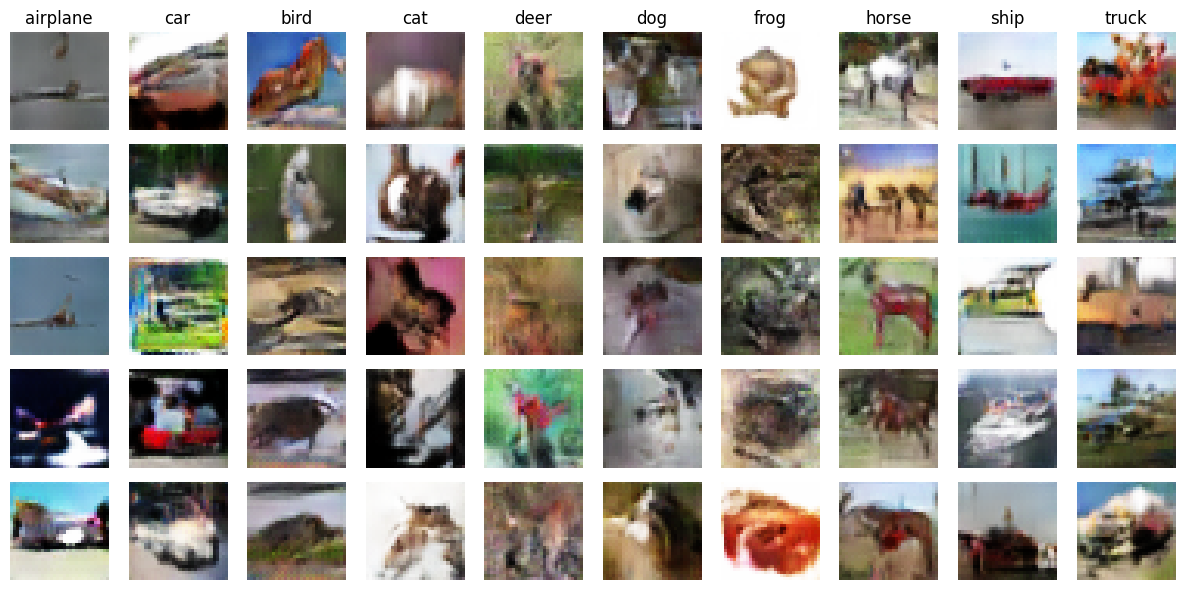

In [117]:
latent_size = 100
num_classes = 10
generator = Generator(latent_size, num_classes).to(device)
generator.load_state_dict(torch.load("final_models/final_generator.pth", map_location=device))
display_test_samples(generator, device)

In [ ]:
generator, discriminator = train_model(gen_pth="./saved_models3/epoch/generator_1025.pth",
                                       disc_pth="./saved_models3/epoch/discriminator_1025.pth",
                                       start_epoch=1026,
                                       num_epochs=2000, 
                                       save_epochs=25, 
                                       models_path="./saved_models3", 
                                       progress_path="./progress3")